![cropped-SummerWorkshop_Header.png](../../../resources/cropped-SummerWorkshop_Header.png)



<h2 align="center"> Using regression to quantify coding of running speed and pupil diameter </h2> 
<h3 align="center"> SWDB 2024 - Day 2 - Single cell coding</h3> 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

<h3> Behavior, attention, and learning shape sensory coding </h3>

<p> Many studies over the last decade have shown that animal behavior, attention, and learning can influence neural coding even in sensory areas, often in a cell type specific way. Here are a few examples: 

* Animal movements, including locomotion, can alter the gain of sensory responses in the visual cortex **(Niell 2011; Darladat 2017)** and aross the brain **(Steinmetz 2019)**. 
* The influence of movement on sensory coding can be cell type specific **(DiPoppa, 2018)** and different populations of inhibitory neurons are jointly modulated by behavior and sensory features in distinct ways **(Millman 2020)**.
* Attention and arousal (alertness), as indexed by pupil diameter, are associated with enhanced sensory coding through changes in neural correlations among specific cell types **(Poort 2022)**.
* Sensory tuning can also be shaped by learning to associate a stimulus with a reward **(Shuler 2006, panel b)**, sharpening tuning and enhancing response reliability **(Poort 2018; Khan 2020)**. 
* Repeated experience with a sensory stimulus can lead to changes in neural representations, including developing predictive activity and expectation signals **(Fiser 2016)**
* Novelty, surprise, and stimulus omission also reveal cell type specific differences in coding properties **(Garrett 2019, 2023)**.

Here is a brief review of these findings: https://doi.org/10.1016/j.conb.2018.04.020 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

<h3> A key question is - How do individual neurons represent information about locomotion, arousal, and behavioral state?</h3>

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

<h4> Coding for running speed and pupil diameter </h4>
<p> 

Both the Visual Coding and Visual Behavior datasets include the animal's **running speed and pupil diameter** in addition to neural measurements. 

In the **Visual Behavior** dataset, the mouse is actively performing a task and attending to the visual stimulus. The animal's running speed is unrelated to the task and mice can choose to run or stop as they please. Interestingly, examination of running behavior during task performance indicates that mice often slow down and stop when they respond to a change stimulus, and also appear to modulate their running in anticipation of stimulus onset. In addition, there are interesting pupil dynamics that occur during the task, and in the spontaneous activity periods before and after the task. 

In this notebook, we will ask questions about single cell coding of behavior features using the **Visual Behavior** dataset. An interesting extension would be to compare to the **Visual Coding** dataset, or to **passive** sessions within the Visual Behavior dataset, to see if active task performance influences the coupling of cell activity with behavior variables compared to when mice passively view visual stimuli. 

You can see an example of mouse behavior during the **change detection task** in the **Visual Behavior** dataset in the plot below. The blue bars indicate the time of image changes, and the gray bars represent repeated image presentations. 

</div>

![behavior_timeseries_color.png](../../../resources/behavior_timeseries_color.png)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

In this exercise, first we will load a dataset and examine `running_speed` and `pupil_width`. 

Then we will use the `brain_observatory_utilities` to align neural activity and behavior to stimulus onset, and compute the mean value of each measure during each stimulus presentation. 

We will use the average cell activity, running, and pupil for each `stimulus_presentation` as the input to our Linear Regression model, and examine the contribution of each feature to single cell activity. 



<div style="background: #E6E6FA; border-radius: 3px; padding: 10px;">
<p>

### Data access - loading an experiment of interest

In [1]:
# We need to import these modules to get started
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# seaborn makes pretty plots & sets font sizes nicely
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

# magic functions for jupyter notebook plotting
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# confirm that you are currently using the newest version of SDK (2.16.2)
import allensdk
allensdk.__version__

'2.16.2'

#### Use the AllenSDK's `VisualBehaviorOphysProjectCache` class to load the `ophys_experiment_table`.

In [3]:
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/"

In [5]:
# import behavior projet cache class from SDK to be able to load the data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

cache = VisualBehaviorOphysProjectCache.from_local_cache(cache_dir=data_root, use_static_cache=True)
# if we needed to download the data we could have used the following line
# cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_root)  

/home/matt.davis/code/AllenSDK/allensdk/brain_observatory/behavior/behavior_project_cache/behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


In [6]:
# Get metadata table for all ophys experiments
ophys_experiment_table = cache.get_ophys_experiment_table()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Get an experiment and load the data from the cache.


In [7]:
# This is our experiment from yesterday that had interesting looking activity
ophys_experiment_id = 951980471

# check the metadata to see what conditions it was imaged in
ophys_experiment_table.loc[ophys_experiment_id]

behavior_session_id                                                    951520319
ophys_session_id                                                       951410079
ophys_container_id                                                    1018028342
mouse_id                                                                  457841
indicator                                                                GCaMP6f
full_genotype                      Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt
driver_line                                                       [Sst-IRES-Cre]
cre_line                                                            Sst-IRES-Cre
reporter_line                                         Ai148(TIT2L-GC6f-ICL-tTA2)
sex                                                                            F
age_in_days                                                                  206
imaging_depth                                                                150
targeted_structure          

In [8]:
# Load the data using the cache
ophys_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id)

behavior_ophys_experiment_951980471.nwb: 100%|██████████| 248M/248M [00:14<00:00, 16.9MMB/s]    
/data/learning/mattd/miniconda3/envs/dev/lib/python3.8/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


<div style="background: #E6E6FA; border-radius: 3px; padding: 10px;">
<p>

### Data streams: running, pupil, neural activity, and stimulus presentations

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

<h4> Examining behavior variables </h4>

Let's start by looking at running speed and pupil diameter and assessing their relationships to each other and to neural activity. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Get the `running_speed` attribute of the `ophys_experiment` data object and plot the running speed. 

Remember that running speed is sampled at the stimulus display frequency, so you can use `stimulus_timestamps` to plot time on the x-axis. 

Text(0.5, 1.0, 'Ophys experiment ID 951980471')

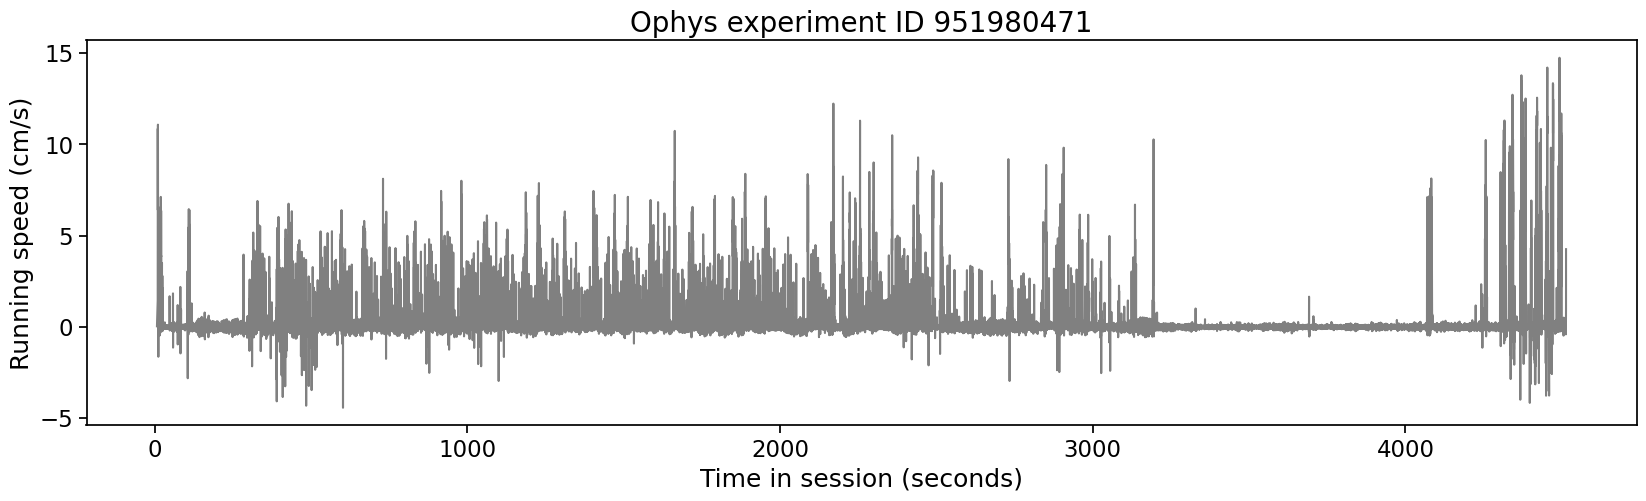

In [9]:
# Plot the running speed, with stimulus_timestamps on x-axis

fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(ophys_experiment.stimulus_timestamps, ophys_experiment.running_speed['speed'], color='gray', linestyle='-')
ax.set_xlabel('Time in session (seconds)')
ax.set_ylabel('Running speed (cm/s)')
ax.set_title('Ophys experiment ID {}'.format(ophys_experiment_id), fontsize = 20)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Examine the `eye_tracking` attribute of the dataset object. What are the columns? 

Plot `pupil_area` over time. 

In [10]:
# Whats in the eye_tracking table?
ophys_experiment.eye_tracking.head()

,timestamps,cr_area,eye_area,pupil_area,likely_blink,pupil_area_raw,cr_area_raw,eye_area_raw,cr_center_x,cr_center_y,...,eye_center_x,eye_center_y,eye_width,eye_height,eye_phi,pupil_center_x,pupil_center_y,pupil_width,pupil_height,pupil_phi
frame,,,,,,,,,,,,,,,,,,,,,
0,0.15829,183.586742,63999.056889,12139.327201,False,12139.327201,183.586742,63999.056889,346.607136,223.948715,...,359.155663,206.109419,159.882116,127.415955,-0.104048,324.758778,217.811200,62.161627,61.233369,-0.537537
1,0.17177,183.453405,63878.120921,12255.297397,False,12255.297397,183.453405,63878.120921,346.946852,224.188518,...,359.295294,205.999745,160.111177,126.993242,-0.109490,324.781277,218.094581,62.457844,61.034058,-0.507705
2,0.18748,176.245497,63975.675600,12128.875269,False,12128.875269,176.245497,63975.675600,346.735257,224.643936,...,358.987745,206.186120,159.889628,127.363421,-0.110130,325.287244,217.632501,62.134861,61.513908,0.731344
3,0.20904,182.139778,63997.358050,12394.953413,False,12394.953413,182.139778,63997.358050,346.869934,224.778881,...,359.471260,206.022686,159.963601,127.347669,-0.106686,325.115191,218.329534,62.812707,60.753917,-0.113071
4,0.24243,186.747323,64046.312897,12436.578877,False,12436.578877,186.747323,64046.312897,346.672515,224.512521,...,359.413554,206.041874,160.226985,127.235588,-0.112555,324.953067,217.859342,62.918090,59.972431,-0.252311


Text(0.5, 1.0, 'Ophys experiment 951980471')

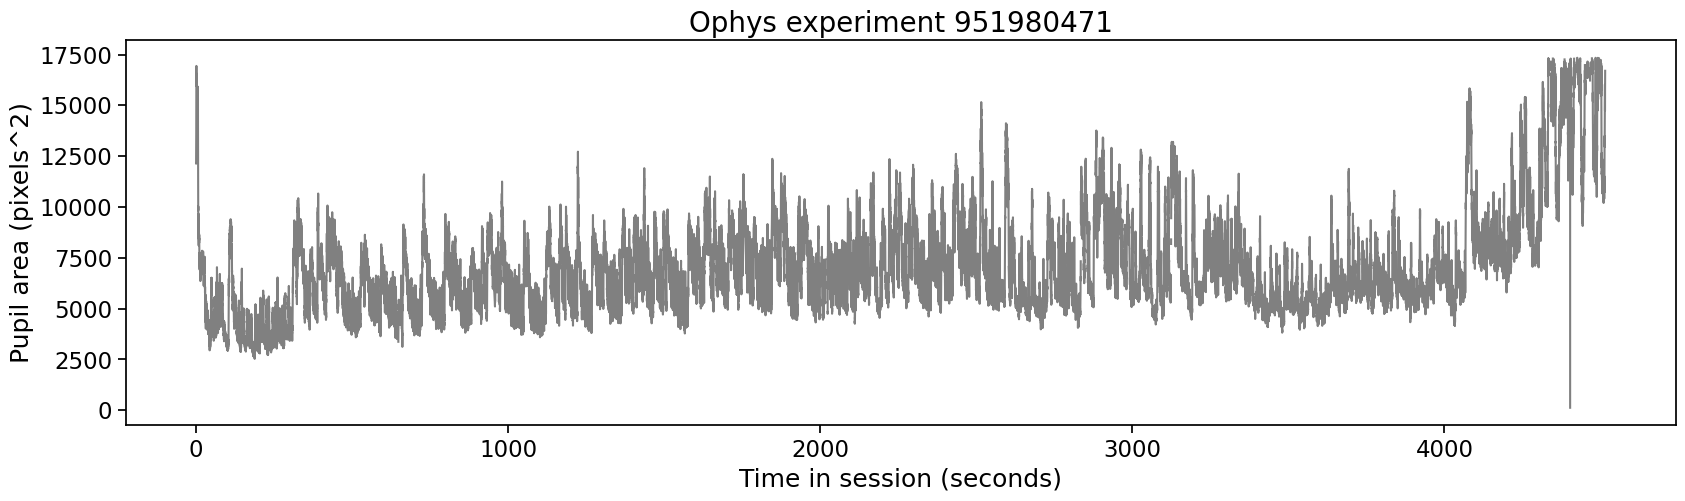

In [11]:
# Plot the pupil area over time
fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(ophys_experiment.eye_tracking.timestamps, ophys_experiment.eye_tracking.pupil_area, color='grey')
ax.set_xlabel('Time in session (seconds)')
ax.set_ylabel('Pupil area (pixels^2)')
ax.set_title('Ophys experiment {}'.format(ophys_experiment_id), fontsize = 20)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Plot the `running_speed` and `pupil_area` on the same axies

Text(0.5, 1.0, 'Ophys experiment 951980471')

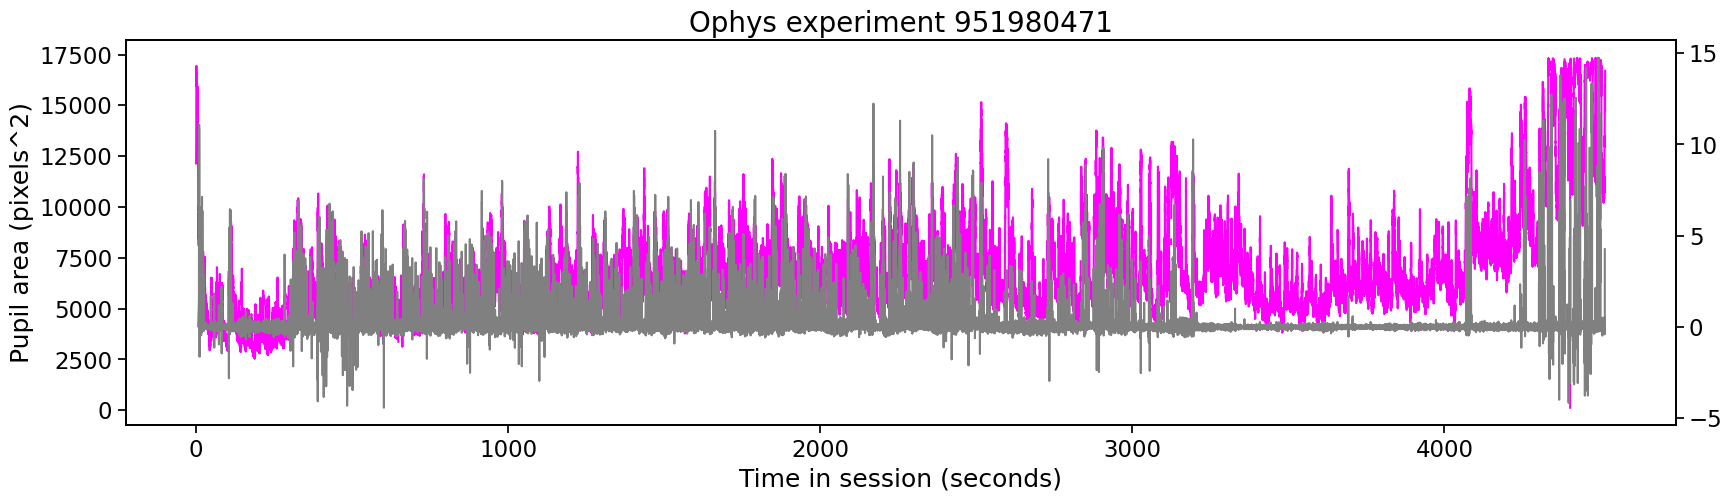

In [12]:
fig, ax = plt.subplots(1,1, figsize = (20,5))

ax.plot(ophys_experiment.eye_tracking.timestamps, ophys_experiment.eye_tracking.pupil_area, color='magenta')

ax2 = ax.twinx()
ax2.plot(ophys_experiment.stimulus_timestamps, ophys_experiment.running_speed['speed'], color='gray', zorder=0)

ax.set_xlabel('Time in session (seconds)')
ax.set_ylabel('Pupil area (pixels^2)')
ax.set_title('Ophys experiment {}'.format(ophys_experiment_id), fontsize = 20)

Ok now lets get the neural activity traces and timing of stimuli during the task

#### Get dF/F traces and events, along with stimulus presentations

In [14]:
# First get all the data we need

# Get normalized fluorescence traces
dff_traces = ophys_experiment.dff_traces.copy()

# Get deconvolved events
events = ophys_experiment.events.copy()

# Get timestamps 
ophys_timestamps = ophys_experiment.ophys_timestamps.copy()

# Get stimulus presentations
stimulus_presentations = ophys_experiment.stimulus_presentations.copy()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Plot one cell's dF/F trace, with time in seconds on the x-axis.


How can we relate cell activity to running speed or pupil diameter?

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Check the `metadata` attribute of the ophys experiment dataset object. 

What is the `ophys_frame_rate`? What is the `stimulus_frame_rate`?

How would you go about aligning signals acquired at different rates?

<div style="background: #E6E6FA; border-radius: 3px; padding: 10px;">
<p>

### Aligning neural activity and behavior to stimulus presentations

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

<h4> Binning continuous data </h4>

One challenge in working with these data is that running, eye tacking, and neural activity are all sampled on separate data streams with different timestamps. This means that even though these data were all collected at the same time, there isn't necessarily a one-to-one matchup between timestamps in one data stream or other.

The most common solution to this solution to this problem is data **resampling**. Typically timestamp bins are defined, and data are resampled into a common time stream. **What size bin should you use?** This depends on the timescale that is relevant to the analysis at hand.

For today, we will be using stimulus-presentation bins to look at our data over a relatively large timescale. Specifically, we will use the `stimulus_response_df` that we generated above, which contains the mean response for each stimulus presentation, along with the `annotated_stimulus_presentations` table that we merged into it, which contains the mean running speed for each stimulus presentation. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

We are going to quantify the average `running_speed` and `pupil_width` during each stimulus presentation, and use those values to compare to the average cell activity for each stimulus presentation. 

This is equivalent to binning at the stimulus presentation frequency.

#### Annotating `stimulus_presentations` with task events and behavior

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

We can use the `brain_observatory_utilities` to annotate the `stimulus_presentations` table with information about what happened during each stimulus, including timing of `licks`, `rewards`, and whether the trial was a <b>hit</b> or a <b>miss</b> trial. 

It will also add the average `running_speed` and `pupil_width` for each stimulus presentation. These can be used to filter data, or plot directly against cell activity to ask about he relationship between running and neural activity. 



he `get_annotated_stimulus_presentations` function takes in the `ophys_experiment` object, which contains everything it needs to know about stimulus presentations, licks, rewards, running, etc., and returns an annotated version of the `stimulus_presentations` table.

Let's go ahead and annotate our `stimulus_presentations`.

In [15]:
import brain_observatory_utilities.datasets.behavior.data_formatting as behavior_utils

In [16]:
# Provide dataset object to run the function
annotated_stimulus_presentations = behavior_utils.get_annotated_stimulus_presentations(ophys_experiment)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

What are the columns of the `annotated_stimulus_presentations` table?

In [17]:
# Check out all the new columns! 
annotated_stimulus_presentations.columns

Index(['stimulus_block', 'stimulus_block_name', 'image_index', 'image_name',
       'movie_frame_index', 'duration', 'start_time', 'end_time',
       'start_frame', 'end_frame', 'is_change', 'is_image_novel', 'omitted',
       'movie_repeat', 'flashes_since_change', 'trials_id', 'active',
       'is_sham_change', 'stimulus_name', 'licks', 'mean_running_speed',
       'mean_pupil_width', 'change_time', 'go', 'catch', 'aborted',
       'auto_rewarded', 'hit', 'miss', 'false_alarm', 'correct_reject',
       'response_time', 'reward_time', 'reward_volume', 'response_latency',
       'time_from_last_change', 'pre_change', 'licked', 'lick_on_next_flash',
       'pre_omitted', 'post_omitted', 'reward_rate', 'engaged',
       'engagement_state', 'epoch'],
      dtype='object')

Great now we have the `mean_running_speed` and `mean_pupil_area` for each stimulus presentation.

Next we need to align the cell traces to the stimulus presentation times, and compute the mean during each stimulus to compare to running and pupil.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

#### Extracting stimulus aligned cell activity with `get_stimulus_response_df()`

One challenge in extracting stimulus aligned activity is that the ophys data and stimulus presentations are sampled at different frequencies, as we saw above, so it is not possible to simply index from one into the other. 

If we want to compute stimulus and behavior aligned cell activity, we will need a way to associate ophys timestamps with the nearest stimulus timestamps. This can be tricky and time consuming.

We can use the `get_stimulus_response_df` function from the `brain_observatory_utilities.datasets.optical_physiology.data_formatting` module to get the stimulus locked activity for all cells in the dataset. 

We already aligned `running_speed` and `pupil_width` to the stimulus onset times above, so we will then be able to link neural activity and behavior on a stimulus by stimulus basis. 


To understand how the `get_stimulus_response_df` function  works in more detail, you can check the documentation, or go through the tutorial on how this function works here: https://github.com/AllenInstitute/brain_observatory_utilities/blob/main/example_notebooks/event_triggered_response_demo.ipynb 


In [18]:
import brain_observatory_utilities.datasets.optical_physiology.data_formatting as data_formatting

In [19]:
# Get dF/F traces aligned to image changes, and take the mean in a 1 second response window

stimulus_response_df = data_formatting.get_stimulus_response_df(ophys_experiment, data_type='dff', event_type='changes',
                                                            time_window=[-1, 2], response_window_duration=1)
stimulus_response_df.head()

100%|██████████| 12/12 [00:00<00:00, 37.67it/s]


,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,p_value_gray_screen,ophys_frame_rate,data_type,event_type,interpolate,output_sampling_rate,response_window_duration
0,19,1086613265,"[-0.055681996047496796, -0.055681996047496796,...","[-1.0, -0.992230738024564, -0.984461476049128,...",0.010775,-0.038663,1.0,11.0,dff,changes,True,None,1
1,19,1086613823,"[0.10811472684144974, 0.10811472684144974, 0.1...","[-1.0, -0.992230738024564, -0.984461476049128,...",-0.028340,-0.072635,1.0,11.0,dff,changes,True,None,1
2,19,1086614149,"[-0.10819042474031448, -0.10819042474031448, -...","[-1.0, -0.992230738024564, -0.984461476049128,...",-0.003289,-0.016205,1.0,11.0,dff,changes,True,None,1
3,19,1086614351,"[0.23392416536808014, 0.23392416536808014, 0.2...","[-1.0, -0.992230738024564, -0.984461476049128,...",-0.087595,0.180126,1.0,11.0,dff,changes,True,None,1
4,19,1086614819,"[0.018694309517741203, 0.018694309517741203, 0...","[-1.0, -0.992230738024564, -0.984461476049128,...",0.743737,0.536262,0.0,11.0,dff,changes,True,None,1


Note that the `stimulus_presentations_id` column is incuded in the table. This can be used to merge in the stimulus metadata from the `stimulus_presentations` table so that you can sort the cell responses by different stimulus and task conditions. 


Merge `stimulus_response_df` with `annotated_stimulus_presentations` table

In [20]:
# Merge the tables, and this time we will assign the results to the original variable name for `stimulus_response_df`
stimulus_response_df = stimulus_response_df.merge(annotated_stimulus_presentations, on='stimulus_presentations_id')
stimulus_response_df.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,p_value_gray_screen,ophys_frame_rate,data_type,event_type,...,time_from_last_change,pre_change,licked,lick_on_next_flash,pre_omitted,post_omitted,reward_rate,engaged,engagement_state,epoch
0,19,1086613265,"[-0.055681996047496796, -0.055681996047496796,...","[-1.0, -0.992230738024564, -0.984461476049128,...",0.010775,-0.038663,1.0,11.0,dff,changes,...,0.0,False,True,True,False,False,inf,True,engaged,0
1,19,1086613823,"[0.10811472684144974, 0.10811472684144974, 0.1...","[-1.0, -0.992230738024564, -0.984461476049128,...",-0.028340,-0.072635,1.0,11.0,dff,changes,...,0.0,False,True,True,False,False,inf,True,engaged,0
2,19,1086614149,"[-0.10819042474031448, -0.10819042474031448, -...","[-1.0, -0.992230738024564, -0.984461476049128,...",-0.003289,-0.016205,1.0,11.0,dff,changes,...,0.0,False,True,True,False,False,inf,True,engaged,0
3,19,1086614351,"[0.23392416536808014, 0.23392416536808014, 0.2...","[-1.0, -0.992230738024564, -0.984461476049128,...",-0.087595,0.180126,1.0,11.0,dff,changes,...,0.0,False,True,True,False,False,inf,True,engaged,0
4,19,1086614819,"[0.018694309517741203, 0.018694309517741203, 0...","[-1.0, -0.992230738024564, -0.984461476049128,...",0.743737,0.536262,0.0,11.0,dff,changes,...,0.0,False,True,True,False,False,inf,True,engaged,0


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

What are the columns of your new `stimulus_response_df` after merging with `annotated_stimulus_presentations`?

In [21]:
# Check out the columns available
stimulus_response_df.columns

Index(['stimulus_presentations_id', 'cell_specimen_id', 'trace',
       'trace_timestamps', 'mean_response', 'baseline_response',
       'p_value_gray_screen', 'ophys_frame_rate', 'data_type', 'event_type',
       'interpolate', 'output_sampling_rate', 'response_window_duration',
       'stimulus_block', 'stimulus_block_name', 'image_index', 'image_name',
       'movie_frame_index', 'duration', 'start_time', 'end_time',
       'start_frame', 'end_frame', 'is_change', 'is_image_novel', 'omitted',
       'movie_repeat', 'flashes_since_change', 'trials_id', 'active',
       'is_sham_change', 'stimulus_name', 'licks', 'mean_running_speed',
       'mean_pupil_width', 'change_time', 'go', 'catch', 'aborted',
       'auto_rewarded', 'hit', 'miss', 'false_alarm', 'correct_reject',
       'response_time', 'reward_time', 'reward_volume', 'response_latency',
       'time_from_last_change', 'pre_change', 'licked', 'lick_on_next_flash',
       'pre_omitted', 'post_omitted', 'reward_rate', 'engaged'

We now have the `mean_running_speed` and `mean_pupil_width` for each stimulus presentation, along with each neuron's `mean_response` in the same window after stimulus onset for each stimulus presentation.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Using the `stimulus_response_df`, get the `mean_response` for one cell and plot `mean_running_speed` and `mean_response` against each other. 

Each point will represent one stimulus presentation during the task. 

Bonus: Color the data points based on other relevant information about each stimulus presentation, such as which `image_name` was shown, whether the `is_change` or `omitted` columns are True, or whether the trial was a `hit` or a `miss`. 

In [22]:
# Get the stimulus response dataframe just for a particular cell
cell_index = 0
cell_specimen_id = ophys_experiment.cell_specimen_table.index.values[cell_index]
cell_df = stimulus_response_df[stimulus_response_df.cell_specimen_id==cell_specimen_id]

Now that we have binned data, lets try plotting the relationship between running speed and the activity of our cell.  


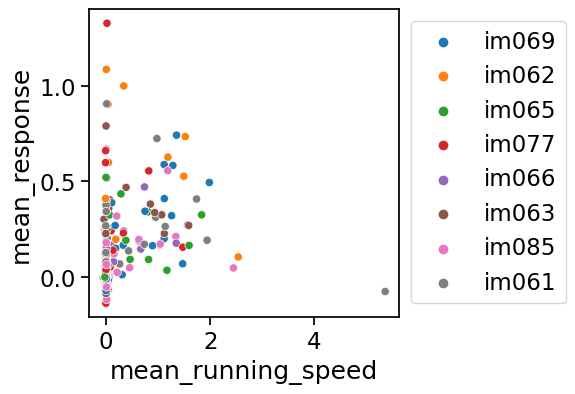

In [23]:
# Plot this cells mean response versus running speed for each stimulus presentation
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(data=cell_df, x='mean_running_speed', y='mean_response', 
                hue='image_name', ax=ax)
ax.legend(bbox_to_anchor=(1,1))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Repeat using the `mean_pupil_width` column.

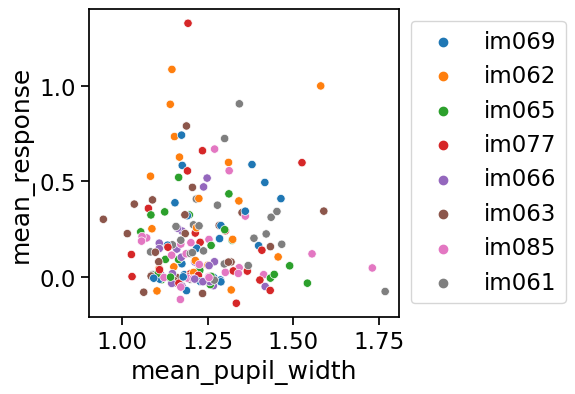

In [24]:
# Plot mean pupil width across trials against this cells mean response
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(data=cell_df, x='mean_pupil_width', y='mean_response', 
                hue='image_name', ax=ax)
ax.legend(bbox_to_anchor=(1,1))

Great! Our cell encodes both pupil diameter and running speed. 

You will recall, however, that these variables themselves are also correlated looked like they might have had a relationship to each other. 

Now that we have nicely binned data, try explicitly plotting the relationship between `mean_pupil_width` and `mean_running_speed`. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Plot the relationship between `mean_pupil_width` and `mean_running_speed`. 

How correlated are these two variables? Use the `pearsonr` function from the `scipy.stats` package to quantify the correlation.

In [25]:
from scipy.stats import pearsonr

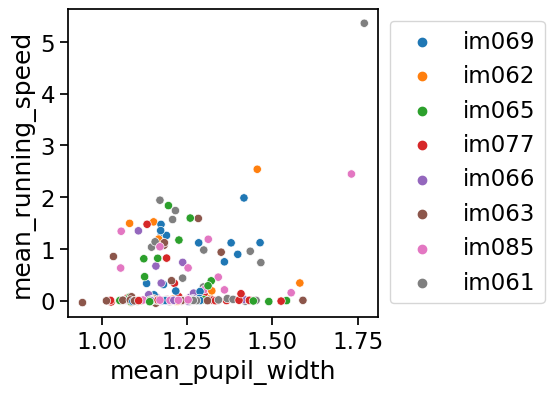

In [26]:
# Plot pupil width and running speed binned by stimulus presentations against each other

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(data=cell_df, x='mean_pupil_width', y='mean_running_speed', 
                hue='image_name', ax=ax)
ax.legend(bbox_to_anchor=(1,1))

How correlated are our two variables? 

In [27]:
# Compute the correlation of X and y (pupil width and cell activity)

pupil = cell_df.mean_pupil_width.values
running = cell_df.mean_running_speed.values

pearson_corr, pearson_pval = pearsonr(pupil, running)
pearson_corr

0.26302250606913946

So...which of the factors best explains the variability in trial-to-trial responses of individual cells?

In the next section, we will use Linear Regression to quantify the contribution of running and pupil to neural activity across trials. 

<div style="background: #E6E6FA; border-radius: 3px; padding: 10px;">
<p>

<h3> Are cells tuned for running speed and pupil diameter? </h3>

Studies have shown that animal movement and overall arousal state can influence the gain of sensory tuning. Running and other movements are also directly encoded by some neurons in the visual cortex, independent of stimulus identity. 

Let's use the Linear Regression techniques we learned in workshop 1 to evaluate single cell coding of running and pupil. 


In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

We will use the funciton below to fit and evaluate our models. Read through the documentation and the code in the function to understand how it works. 

In [29]:
def crossValidateLinearModel(X, y, n_split = 5, shuffle = False, shuffle_seed = None):
    '''
    Cross validate a linear model using KFold cross validation

    Parameters
    ----------
    X : np.array
        The input data to fit
    y : np.array
        The output data to fit
    n_split : int
        The number of splits to use
    shuffle : bool
        Whether or not to shuffle the data
    shuffle_seed : int
        The seed to use for shuffling the data

    Returns
    -------
    Mean Score: float
        The average cross validation score
    Model List: list    
        The models fit to each fold of the data
    Test score: np.array    
        The cross validation scores for testing data each fold
    Train score: np.array
        The cross validation scores for testing data each fold
    '''

    if len(X.shape)==1:
        X = X.copy().reshape(-1,1)
    # Initialize KFold object
    folderizer = KFold(n_splits=n_split, shuffle=shuffle, random_state=shuffle_seed)
    # Create an array to save the results
    self_score = np.empty(n_split)
    cross_score = np.empty(n_split)
    models = [None]*n_split
    # Loop through the folds, fit the model, and save the results
    for ii, (train_index, test_index) in enumerate(folderizer.split(X, y)):
        models[ii] = LinearRegression(fit_intercept=False).fit(X[train_index,:], y[train_index])
        self_score[ii] = models[ii].score(X[train_index,:], y[train_index])
        cross_score[ii] = models[ii].score(X[test_index,:], y[test_index])
        
    return np.mean(cross_score), models, cross_score, self_score

Note that the `KFold` object includes both `shuffle` and `shuffle_seed` parameters. `shuffle` does exactly what it sounds like- it randomizes the set data points included in each fold. `shuffle_seed` can be used to get reproducible results from this shuffling. This is particularly important if we want to compare models- using the same shuffle seed will give the same random set of trials across function calls.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>
<h4> Which variables contribute to our model prediction? </h4>

By fitting models with different combinations of features, we can get a richer sense of how different features are encoded by neural activity. 

One option for doing this is simply to fit a model to each variable of interest and compare their performance. This answers a very simple question: how much of a cells variability can be explained by this particular feature. We will see, however, that when variables are correlated the outcome of such one-at-a-time model fits can be difficult to interpret. 


First we will create an `X` matrix for each variable we want to test: stimulus, pupil, and running, along with a `y` matrix for the variable we want to predict: one cell's activity across trials. 

We can use the `mean_pupil_width`, `mean_running_speed` and `mean_response` columns of the `stimulus_response_df` for our cell to create one X matrix for each feature. 

In [30]:
# y is our cell activity
y = cell_df.mean_response.values

In [31]:
# Create a design matrix for images

# initialize an empty matrix that is the length of the number of image presentations by 8, the number of unique images
# Get the image presentations for all the change trials in our stim response df
image_presentations = cell_df.image_name.values
X_stim = np.zeros((len(image_presentations), 8))

image_names = np.unique(image_presentations)
# Loop through image presentations and set the column corresponding to that image index to 1 for each row
for i, image_name in enumerate(image_presentations):
    image_index = np.where(image_names==image_name)[0][0]
    X_stim[i, image_index] = 1

In [32]:
# Create design matrix for pupil & running
X_pupil = cell_df.mean_pupil_width.values
X_running = cell_df.mean_running_speed.values

In [33]:
# What are their shapes?
print('X_stim:', X_stim.shape)
print('X_pupil:', X_pupil.shape)
print('X_running:', X_running.shape)

X_stim: (186, 8)
X_pupil: (186,)
X_running: (186,)


Now we will use our `crossValidateLinearModel` function to test how well each individual feature predicts this cell's activity.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Use the `crossValidateLinearModel` function we created above to cross-validate and test our linear model for each of the variables separately. 

Which one produces the highest score? Use the `crossValidateLinearModel` function provided above.

In [34]:
# Now use our fancy new function to test a bunch of models.
seed = 5
x_stim_score,_,_,_  = crossValidateLinearModel(X_stim, y, shuffle=True, shuffle_seed=seed)
print(f'Stimulus model score {x_stim_score}')

x_pupil_score,_,_,_  = crossValidateLinearModel(X_pupil, y, shuffle=True, shuffle_seed=seed)
print(f'Pupil model score {x_pupil_score}')

x_running_score,_,_,_  = crossValidateLinearModel(X_running, y, shuffle=True, shuffle_seed=seed)
print(f'Running model score {x_running_score}')

Stimulus model score -0.13693258850283313
Pupil model score -0.09838355934535863
Running model score -0.33464103874133283


How does the model do on individual features? 

What about combinations of features? 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

<h4> Multiple linear regression - predicting activity based on a combination of features</h4>

Instead of looking at the model fits for each feature individually, we can also create a model to explain neural activity based on a combination of features. To test the contribution of each feature, we can systematically remove each one to evaluate how much variance explained changes when that feature is missing. 


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Create an X matrix that incorporates stimulus, pupil, and running, and evaluate performance of the model with all features included.

In [35]:
# Stack up the x matrices to make one big feature matrix
# Note that pupil and running have to be reshaped to be able to stack with X_stim which has multiple columms already
X_combo = np.hstack((X_stim, X_pupil.reshape(-1, 1), X_running.reshape(-1,1)))
X_combo.shape

(186, 10)

In [36]:
# Provide X_combo and y to the function
x_combo_score,_,_,_  = crossValidateLinearModel(X_combo, y, shuffle = True, shuffle_seed=seed)
print(f'Combined model score {x_combo_score}')

Combined model score -0.15582653512056416


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

Importantly, we cannot simply look at the model coefficients, as we did in the "stimulus only" example. This is because our model now contains different types of features with different magnitudes, and there is not a clear mapping between them. While the weights we fit will scale accordingly, they can no longer be directly compared. Visualizing the design matrix illustrates this problem.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Plot the combined X matrix as a heatmap, zooming in on the first 20 stimulus presentations (i.e. rows). What are the columns of this matrix? 

What do each of the features look like? Do they have the same units?

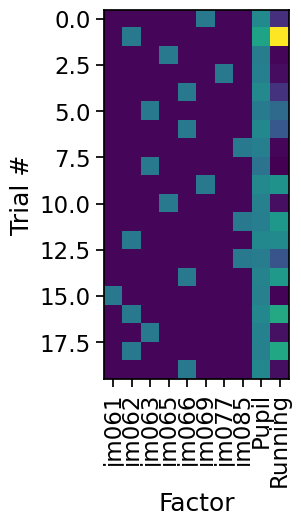

In [37]:
fig,ax = plt.subplots()

# For labeling our plot
xlabels = image_names.copy()
xlabels = np.append(xlabels,'Pupil')
xlabels = np.append(xlabels,'Running')

ax.imshow(X_combo[:20])
ax.set_ylabel('Trial #')
ax.set_xlabel('Factor')

ax.set_xticks(np.arange(0,len(xlabels)))
ax.set_xticklabels(xlabels,rotation = 90);


Here the columns are images 1-8, then running speed for each trial, then pupil width for each trial. 

The image features are one-hot encoded (i.e. represented by zeros or ones). Pupil and running are continuous variables. 

How might this influence our model fit? 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

It is worth noting that `Scikit-Learn` has a tool called the `StandardScaler` that will normalize model inputs. This is useful if you want or need to more explicity compare coefficient weights across variables of different types, but we won't worry about that for now. You can read more about it here: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

<h4> Leave one out test </h4>

To test the encoding of any particular feature in a multiple linear regression model, we can compare the variance explained in the full model with reduced models with only a subset of the features. 

Specifically, we can systematically drop out feature one at a time and see how model performance changes. If the model gets worse, it suggests that this feature was explaining some of the variance in our data. Because other features are still included, this method is a way to avoid mistakenly assuming that a cell encodes all of a set of correlated variables.

Let's create several design matrices, each with one of the variables left out

In [38]:
# Create each design matrix as a stacked combo of all the features except the one we are leaving out
X_wout_stimulus = np.hstack((X_pupil.reshape(-1,1), X_running.reshape(-1,1)))
X_wout_running =  np.hstack((X_stim, X_pupil.reshape(-1,1)))
X_wout_pupil =  np.hstack((X_stim, X_running.reshape(-1,1)))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Use the `crossValidateLinearModel` function again to test model performance on each of the leave one out design matrices.

In [39]:
# Set seed
seed = 5

# Now use our fancy new function to test a bunch of models.
x_combo_score,_,_,_  = crossValidateLinearModel(X_combo, y, shuffle = True, shuffle_seed=seed)
print(f'Combo {x_combo_score}')

x_wout_stim_score,_,_,_  = crossValidateLinearModel(X_wout_stimulus, y, shuffle = True, shuffle_seed=seed)
print(f'Wout Stim {x_wout_stim_score}')
print(f'Additional variance explained by stim {x_combo_score-x_wout_stim_score}')

x_wout_pupil_score,_,_,_  = crossValidateLinearModel(X_wout_pupil, y, shuffle = True, shuffle_seed=seed)
print(f'Wout Pupil {x_wout_pupil_score}')
print(f'Additional variance explained by pupil {x_combo_score-x_wout_pupil_score}')

x_wout_running_score,_,_,_  = crossValidateLinearModel(X_wout_running, y, shuffle = True, shuffle_seed=seed)
print(f'Wout Running {x_wout_running_score}')
print(f'Additional variance explained by running {x_combo_score-x_wout_running_score}');


Combo -0.15582653512056416
Wout Stim -0.08111259200290899
Additional variance explained by stim -0.07471394311765517
Wout Pupil -0.11634505920278089
Additional variance explained by pupil -0.03948147591778327
Wout Running -0.15755516098837397
Additional variance explained by running 0.0017286258678098076


This cell really isnt well predicted by anything we have tested here... what about some other neurons? 

<div style="background: #E6E6FA; border-radius: 3px; padding: 10px;">
<p>

<h3> Looking across the population </h3>

Let's use the approach we just tried above, using the leave one out test, to assess which features lead to the largest drop in model prediction accuracy across all the neurons in the dataset. 


First we need to build our X matrices for stimulus, running, and pupil

In [40]:
# Create X_stim

# initialize an empty matrix that is the length of the number of image presentations by 8, the number of unique images
# Get the image presentations for all the change trials in our stim response df
image_presentations = cell_df.image_name.values
X_stim = np.zeros((len(image_presentations), 8))

unique_images = np.unique(image_presentations)
# Loop through image presentations and set the column corresponding to that image index to 1 for each row
for i, image_name in enumerate(image_presentations):
    image_index = np.where(image_names==image_name)[0][0]
    X_stim[i, image_index] = 1

# Create design matrices for running and pupil
X_pupil = cell_df.mean_pupil_width.values
X_running = cell_df.mean_running_speed.values


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Loop through all the cells in the dataset and use the `crossValidateLinearModel` function to quantify model performance on the full model, as well as each reduced model with one feature left out. 

Aggregate the model scores across cells. 

In [41]:
# Loop through neurons and compute the model fits
cell_specimen_ids = stimulus_response_df.cell_specimen_id.unique()

# Create a list to aggregate our results
model_scores_list = []
diff_from_full = []
for cell_specimen_id in cell_specimen_ids: 
    cell_data = stimulus_response_df[stimulus_response_df.cell_specimen_id==cell_specimen_id]
    y = cell_data.mean_response.values

    # Now use our fancy new function to test a bunch of models.
    x_combo_score,_,_,_  = crossValidateLinearModel(X_combo, y, shuffle=True, shuffle_seed=seed)

    x_wout_stim_score,_,_,_  = crossValidateLinearModel(X_wout_stimulus, y, shuffle=True, shuffle_seed=seed)

    x_wout_pupil_score,_,_,_  = crossValidateLinearModel(X_wout_pupil, y, shuffle=True, shuffle_seed=seed)

    x_wout_running_score,_,_,_  = crossValidateLinearModel(X_wout_running, y, shuffle=True, shuffle_seed=seed)

    # Aggregate the model fits with each feature left out
    model_scores_list.append([cell_specimen_id, x_combo_score, x_wout_stim_score, x_wout_pupil_score, x_wout_running_score])
    # Aggregate the difference between each dropout and the full model
    # This is the unique variance explained by each feature
    diff_from_full.append([cell_specimen_id, x_combo_score, 
                           x_combo_score-x_wout_stim_score, 
                           x_combo_score-x_wout_pupil_score, 
                           x_combo_score-x_wout_running_score])

# Turn the list into a dataframe
columns = ['cell_specimen_id', 'full_model', 'stimuli', 'pupil', 'running']
dropout_scores = pd.DataFrame(model_scores_list, columns=columns)
unique_var_exp = pd.DataFrame(diff_from_full, columns=columns)

# Set the cell ID as the index
unique_var_exp = unique_var_exp.set_index('cell_specimen_id')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Plot the distribution of model scores for each model that we fit - the full model with all features, and each reduced model with one of the features left out. 

Are the cells well fit by the full model? How about the reduced models? Which features are most strongly encoded by neurons in this ophys experiment?

Text(0.5, 0.98, 'Distributions of variance explained for experiment 951980471 from Sst')

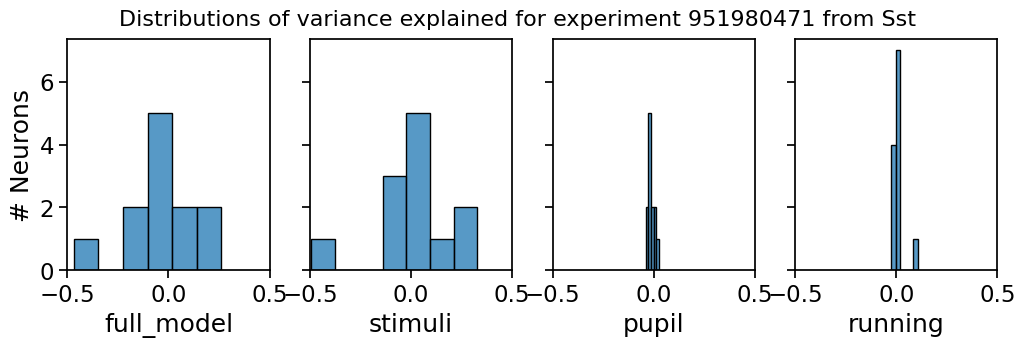

In [42]:
# Plot the distribution for each value
fig, ax = plt.subplots(1, 4, figsize=(12,3), sharey=True,)
for i, column in enumerate(unique_var_exp.columns):
    ax[i] = sns.histplot(unique_var_exp[column], ax=ax[i])
    ax[i].set_xlim(-0.5, 0.5)
    ax[i].set_ylabel('# Neurons')
cell_type = ophys_experiment.metadata['cre_line'].split('-')[0]
plt.suptitle('Distributions of variance explained for experiment '+str(ophys_experiment_id)+' from '+cell_type, fontsize=16)

<div style="background: #E6E6FA; border-radius: 3px; padding: 10px;">
<p>

<h4> Comparing across cell types </h4>

Let's run the same analysis for a Vip experiment and see if there are any differences

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

<h4> A note on cell types & behavior coding </h4>

<p> Many studies have shown that different types of neurons have different encoding of sensory, behavioral, and task variables. 
For example, Somatostatin (Sst) and Vasoactive intestinal peptide (Vip) expressing inhibitory neurons in the visual cortex are known to show modulation by locomotion, arousal, attention, and learning. 

Here is a useful review on how animal behavior and learning influence the coding of different cell types in the visual cortex: 
https://doi.org/10.1016/j.conb.2018.04.020

In addition, Sst and Vip inhibitory neurons are known to mutually inhibit each other and a shift in the balance between them can lead to disinhibition of excitatory neurons under certain conditions, such as with task engagement or novelty or arousal (all conditions that are included in the Visual Behavior Ophys dataset). 

In the <b>Visual Behavior Ophys</b> dataset, 3 different <b>transgenic mouse lines</b> were used to express GCaMP in either <b>excitatory neurons</b> (labeled by the Slc17a7-IRES2-Cre driver line), <b>Sst inhibitory neurons</b> (labeled by the Sst-IRES-Cre driver line), and <b>Vip inhibitory neurons</b>  (labeled by the Vip-IRES-Cre driver line). 

You can learn more about optical physiology and transgenic mouse lines in the <b>*DataBook*</b>. 


![cre_lines.png](../../../resources/cre_lines.png)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Load the data for an experiment with `cre_line` = `Vip-IRES-Cre` using the `VisualBehaviorOphysProjectCache`.

Plot the `max_projection` image to see what the cells look like. 

In [43]:
# Pick an ophys experiment from the Vip-IRES-Cre transgenic line
vip_experiments = ophys_experiment_table[ophys_experiment_table.cre_line=='Vip-IRES-Cre']
ophys_experiment_id = vip_experiments.index.values[20]

# load the dataset
ophys_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id)


behavior_ophys_experiment_1008408506.nwb: 100%|██████████| 257M/257M [00:13<00:00, 19.2MMB/s]    
/data/learning/mattd/miniconda3/envs/dev/lib/python3.8/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


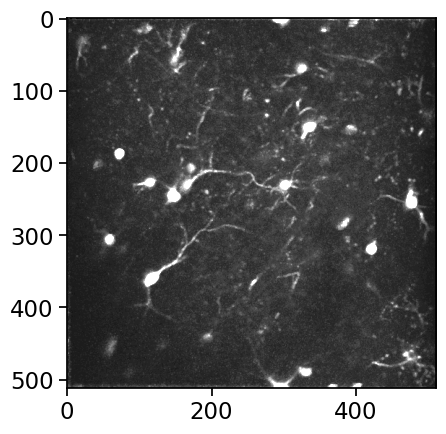

In [44]:

# plot the max projection
plt.imshow(ophys_experiment.max_projection, cmap='gray', vmax=np.percentile(ophys_experiment.max_projection, 99))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Get the `annotated_stimulus_presentations` table (which includes the `mean_running_speed` and `mean_pupil_width` for each stimulus presentation) using the `get_annotated_stimulus_presentations()` function from the `brain_observatory_utilities.datasets.behavior.data_formatting` modeule.

Check the columns of this table to be sure you have the information you need. 

In [45]:
# Provide ophys_experiment dataset object to run the function
annotated_stimulus_presentations = behavior_utils.get_annotated_stimulus_presentations(ophys_experiment)

In [46]:
# Check the colummns 
annotated_stimulus_presentations.columns

Index(['stimulus_block', 'stimulus_block_name', 'image_index', 'image_name',
       'movie_frame_index', 'duration', 'start_time', 'end_time',
       'start_frame', 'end_frame', 'is_change', 'is_image_novel', 'omitted',
       'movie_repeat', 'flashes_since_change', 'trials_id', 'active',
       'is_sham_change', 'stimulus_name', 'licks', 'mean_running_speed',
       'mean_pupil_width', 'change_time', 'go', 'catch', 'aborted',
       'auto_rewarded', 'hit', 'miss', 'false_alarm', 'correct_reject',
       'response_time', 'reward_time', 'reward_volume', 'response_latency',
       'time_from_last_change', 'pre_change', 'licked', 'lick_on_next_flash',
       'pre_omitted', 'post_omitted', 'reward_rate', 'engaged',
       'engagement_state', 'epoch'],
      dtype='object')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Now get the average cell responses using the `get_stimulus_response_df()` funciton from the `brain_observatory_utilities.datasets.optical_physiology.data_formatting` modeule.

Merge the `stimulus_response_df` with the `annotated_stimulus_presentations`, using the `stimulus_presentations_id` column, as we did above.

In [47]:
# Get stimulus aligned responses
stimulus_response_df = data_formatting.get_stimulus_response_df(ophys_experiment, data_type='dff', event_type='changes',
                                                            time_window=[-1, 2], response_window_duration=1,
                                                            interpolate=False, output_sampling_rate=30)
stimulus_response_df.head()

100%|██████████| 17/17 [00:00<00:00, 166.89it/s]


,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,p_value_gray_screen,ophys_frame_rate,data_type,event_type,interpolate,output_sampling_rate,response_window_duration
0,28,1120061901,"[0.011834355262375893, -0.05235622159105691, 0...","[-0.9354808488096723, -0.8419327639287051, -0....",0.078692,-0.012009,0.0000,30,dff,changes,False,30,1
1,28,1120061991,"[0.02788220050764338, -0.006568365849564356, 0...","[-0.9354808488096723, -0.8419327639287051, -0....",0.171657,0.035393,0.8972,30,dff,changes,False,30,1
2,28,1120062281,"[0.0728347105070476, 0.1428563113984076, 0.026...","[-0.9354808488096723, -0.8419327639287051, -0....",0.040308,0.023011,0.0000,30,dff,changes,False,30,1
3,28,1120062800,"[-0.21925772804716567, -0.04413517392033234, -...","[-0.9354808488096723, -0.8419327639287051, -0....",0.442030,0.003510,0.2161,30,dff,changes,False,30,1
4,28,1120063075,"[0.31008986547658646, -0.037653355058960114, 0...","[-0.9354808488096723, -0.8419327639287051, -0....",0.145181,-0.011135,0.8937,30,dff,changes,False,30,1


In [48]:
# Merge the tables using their shared column, the stimulus_presentations_id
stimulus_response_df = stimulus_response_df.merge(annotated_stimulus_presentations, on='stimulus_presentations_id')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

First get the variable we are trying to predict - the stimulus aligned activity of one cell in the dataset. 

We can get this from the `stimulus_response_df`. 

Extract this information for one cell and plot it. 

In [49]:
# Get one cell's data to extract the running and pupil for this session 
cell_specimen_id = stimulus_response_df.cell_specimen_id.unique()[0]
cell_df = stimulus_response_df[stimulus_response_df.cell_specimen_id==cell_specimen_id]

# y is just the mean response for each trial for this cell. Thats the thing we want to predict
y = cell_df.mean_response.values


Text(0.5, 1.0, 'cell_specimen_id:1120061901')

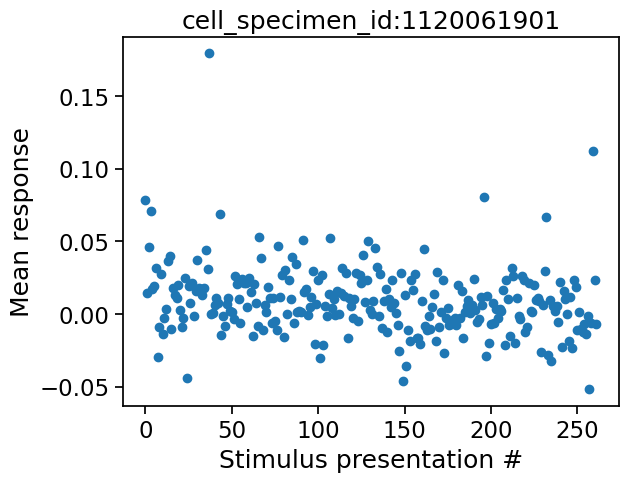

In [50]:
fig, ax = plt.subplots()
ax.plot(y, 'o')
ax.set_xlabel('Stimulus presentation #')
ax.set_ylabel('Mean response')
ax.set_title('cell_specimen_id:'+str(cell_specimen_id))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Now let's create our X matrices for stimulus, running speed, and pupil width, as well as a combined X matrix with all features. 

Create an X matrix for each reduced model as well, with one feature left out. We can compare this to the full model. 


In [51]:
# Create X_stim

# Initialize an empty matrix that is the length of the number of image presentations by 8, the number of unique images
image_presentations = cell_df.image_name.values
X_stim = np.zeros((len(image_presentations), 8))

image_names = np.unique(image_presentations)
# Loop through image presentations and set the column corresponding to that image index to 1 for each row
for i, image_name in enumerate(image_presentations):
    image_index = np.where(image_names==image_name)[0][0]
    X_stim[i, image_index] = 1

# Create design matrices for running and pupil
X_pupil = cell_df.mean_pupil_width.values
X_running = cell_df.mean_running_speed.values

# Combined X matrix
X_combo = np.hstack((X_stim, X_pupil.reshape(-1, 1), X_running.reshape(-1,1)))

# Now create the leave-one-out X matrices 

# Create each design matrix as a stacked combo of all the features except the one we are leaving out
X_wout_stimulus = np.hstack((X_pupil.reshape(-1,1), X_running.reshape(-1,1)))
X_wout_running =  np.hstack((X_stim, X_pupil.reshape(-1,1)))
X_wout_pupil =  np.hstack((X_stim, X_running.reshape(-1,1)))


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Now loop through all cells and aggregate the model fits

In [52]:
# Loop through neurons and compute the model fits
cell_specimen_ids = stimulus_response_df.cell_specimen_id.unique()

# Create a list to aggregate our results
seed = 5
model_scores_list = []
diff_from_full = []
for cell_specimen_id in cell_specimen_ids: 
    cell_data = stimulus_response_df[stimulus_response_df.cell_specimen_id==cell_specimen_id]
    y = cell_data.mean_response.values

    # Now use our fancy new function to test a bunch of models.
    x_combo_score,_,_,_  = crossValidateLinearModel(X_combo, y, shuffle=True, shuffle_seed=seed)

    x_wout_stim_score,_,_,_  = crossValidateLinearModel(X_wout_stimulus, y, shuffle=True, shuffle_seed=seed)

    x_wout_pupil_score,_,_,_  = crossValidateLinearModel(X_wout_pupil, y, shuffle=True, shuffle_seed=seed)

    x_wout_running_score,_,_,_  = crossValidateLinearModel(X_wout_running, y, shuffle=True, shuffle_seed=seed)

    # Aggregate the model fits with each feature left out
    model_scores_list.append([cell_specimen_id, x_combo_score, x_wout_stim_score, x_wout_pupil_score, x_wout_running_score])
    # Aggregate the difference between each dropout and the full model
    # This is the unique variance explained by each feature
    diff_from_full.append([cell_specimen_id, x_combo_score, 
                           x_combo_score-x_wout_stim_score, 
                           x_combo_score-x_wout_pupil_score, 
                           x_combo_score-x_wout_running_score])

# Turn the list into a dataframe
columns = ['cell_specimen_id', 'full_model', 'stimuli', 'pupil', 'running']
dropout_scores = pd.DataFrame(model_scores_list, columns=columns)
unique_var_exp = pd.DataFrame(diff_from_full, columns=columns)

# Set the cell ID as the index
unique_var_exp = unique_var_exp.set_index('cell_specimen_id')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Plot the distribution of model fits for all cells in this experiment, with one plot for the full model, and one for each of the reduced "leave-one-out" models. 

Text(0.5, 0.98, 'Distributions of variance explained for experiment 1008408506 from Vip')

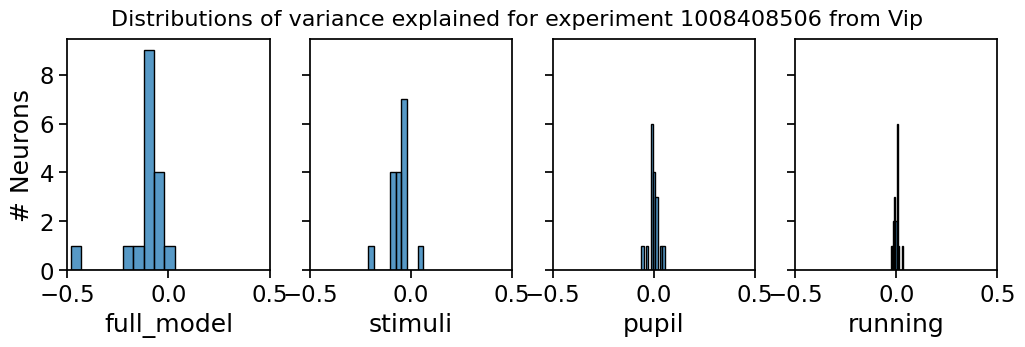

In [53]:
# Plot the distribution for each value
fig, ax = plt.subplots(1, 4, figsize=(12,3), sharey=True,)
for i, column in enumerate(unique_var_exp.columns):
    ax[i] = sns.histplot(unique_var_exp[column], bins=10, ax=ax[i])
    ax[i].set_xlim(-0.5, 0.5)
    ax[i].set_ylabel('# Neurons')
cell_type = ophys_experiment.metadata['cre_line'].split('-')[0]
plt.suptitle('Distributions of variance explained for experiment '+str(ophys_experiment_id)+' from '+cell_type, fontsize=16)

<div style="background: #E6E6FA; border-radius: 3px; padding: 10px;">
<p>

<h4> Reflecting on our results & considering next steps </h4>

How does this set of models do for the Vip cells compared to the Sst cells? 

Are there more cells that encode running or pupil?

What would it look like for another experiment from the same `cre_line`? How variable is neural coding across animals? 

Are there differences cross `imaging_depth`? What about different `session_type`s?

There are many fun projects that could be done using regression to quantify neural coding!! 